<h1>추천시스템</h1>

In [ ]:
# surprise 패키지 설치
!pip install scikit-surprise numpy==1.* opencv-python

In [ ]:
# 라이브러리
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import surprise

In [ ]:
surprise.__version__

'1.1.4'

# MovieLens 평점 데이터

In [ ]:
# MovieLens 100K dataset
# 기존 강의 자료 코드는 Colab 환경, 라이브러리 등의 업데이트로 인해 코드 수정.
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip --no-check-certificate
!unzip -o ml-100k.zip

reader = surprise.Reader(line_format='user item rating timestamp', sep='\t')
data = surprise.Dataset.load_from_file('ml-100k/u.data', reader=reader)

# MovieLens 100K dataset
# 기존 강의 자료 코드는 Colab 환경, 라이브러리 등의 업데이트로 인해 코드 수정
# data = surprise.Dataset.load_builtin(u'ml-100k',prompt=False)


--2025-08-25 07:00:36--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  8.29MB/s    in 0.6s    

2025-08-25 07:00:36 (8.29 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test  

In [ ]:
data.raw_ratings[:5]

[('196', '242', 3.0, '881250949'),
 ('186', '302', 3.0, '891717742'),
 ('22', '377', 1.0, '878887116'),
 ('244', '51', 2.0, '880606923'),
 ('166', '346', 1.0, '886397596')]

In [ ]:
rating_df = pd.DataFrame({
    'user': [ int(u) for (u,i,r,t) in data.raw_ratings ],
    'item': [ int(i) for (u,i,r,t) in data.raw_ratings ],
    'rating': [ r for (u,i,r,t) in data.raw_ratings ]
})

In [ ]:
rating_matrix = rating_df.pivot(index='user',columns='item',values='rating')
rating_matrix

item,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print( rating_matrix.shape, (~rating_matrix.isna()).sum().sum() )

(943, 1682) 100000


In [ ]:
# random_state를 0으로 고정함으로써 train, test 데이터셋을 항상 동일하게 나누게 됨.
trainset, testset = surprise.model_selection.train_test_split(data, test_size=0.25, random_state=0)

# 모델 기반 협업 필터링

KNN 모델

In [ ]:
# 모델 훈련
f = surprise.KNNBasic(
    k = 40,
    sim_options = {
        'name': 'cosine',  # 유사도: cosine, pearson, pearson_baseline
        'user_based': True  # 사용자기반 CF, False라면 아이템기반
    }
  )
f.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
# 특정 경우에 대한 예측
uid, iid = str(196), str(302)
pred = f.predict(uid, iid)
print(pred)

user: 196        item: 302        r_ui = None   est = 3.90   {'actual_k': 40, 'was_impossible': False}


In [ ]:
# 평가 데이터 전체에 대한 예측
preds = f.test(testset)
preds[:5]

[Prediction(uid='120', iid='282', r_ui=4.0, est=3.798419608824813, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='882', iid='291', r_ui=4.0, est=3.399577779546374, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='535', iid='507', r_ui=5.0, est=4.175435371554064, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid='697', iid='244', r_ui=5.0, est=3.2253045859149707, details={'actual_k': 32, 'was_impossible': False}),
 Prediction(uid='751', iid='385', r_ui=4.0, est=3.7011823059700646, details={'actual_k': 40, 'was_impossible': False})]

In [ ]:
# 평가 데이터 전체에 대한 정확도 측정
surprise.accuracy.rmse(preds)

RMSE: 1.0235


1.0234939388401312

In [ ]:
# 파라메터에 따른 성능 변화
np.random.seed(1)
result = []
for k in [20,30,40,50,60,70,80]:
  f = surprise.KNNBasic(k = k,
        sim_options = {'name':'cosine','user_based': True})
  f.fit(trainset)
  preds = f.test(testset)
  acc = surprise.accuracy.rmse(preds)
  result.append([k,acc])

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0314
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0257
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0235
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0225
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0222
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0225
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0228


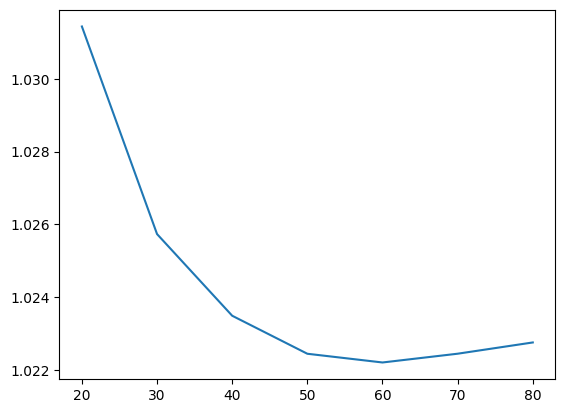

In [ ]:
result = np.array(result)
plt.plot(result[:,0],result[:,1])

SVD

In [ ]:
f = surprise.SVD(n_factors=100)
f.fit(trainset)
preds = f.test(testset)
surprise.accuracy.rmse(preds)

RMSE: 0.9503


0.9502711737387619

In [ ]:
# 파라메터에 따른 성능 변화
np.random.seed(1)
result = []
for n in [10,20,50,100,150,200]:
  f = surprise.SVD(n_factors=n)
  f.fit(trainset)
  preds = f.test(testset)
  acc = surprise.accuracy.rmse(preds)
  result.append([n,acc])

RMSE: 0.9505
RMSE: 0.9470
RMSE: 0.9459
RMSE: 0.9467
RMSE: 0.9514
RMSE: 0.9540


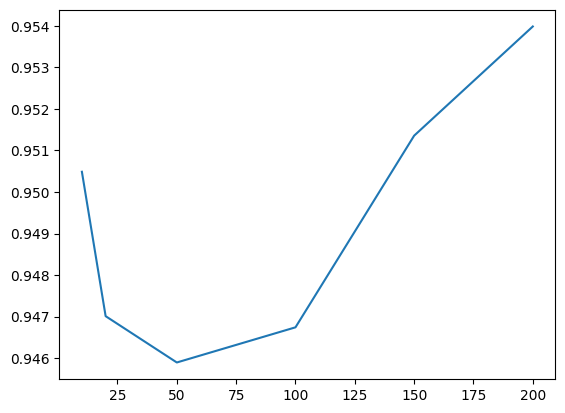

In [ ]:
result = np.array(result)
plt.plot(result[:,0],result[:,1])

# 연습문제

1. 위에서 사용한 KNNBasic 모델을 이용하여 30번 사용자의 150번 아이템에 대한 평점을 예측하시오. sim_options의 유사도 측정 방법을 pearson으로 변경하여라. 예측 평점은 얼마인가? 고정된 결과를 위해서 KNNBasic의 random_state 파라메터는 0으로 고정하여라.

In [ ]:
# 모델 훈련
f = surprise.KNNBasic(
    k = 70,
    sim_options = {
        'name': 'pearson',  # 유사도: cosine, pearson, pearson_baseline
        'user_based': True  # 사용자기반 CF, False라면 아이템기반
    },
    random_state=0
  )
f.fit(trainset)

In [ ]:
# 특정 경우에 대한 예측
uid, iid = str(30), str(150)
pred = f.predict(uid, iid)
print(pred)

2. ```surprise.NMF``` (Non-Negative Factorization)를 이용하여 평점 예측 모델을 만드시오. 고정된 결과를 위해서 NMF의 random_state 파라메터는 0으로 고정하며, 다른 파라메터는 기본적으로 주어지는 파라메터를 사용하시오. 위의 예제와 같이 훈련데이터로 학습하고 평가데이터로 평가하시오. 평가데이터의 MAE는 얼마인가?

In [ ]:
f=surprise.NMF(random_state=0)
f.fit(trainset)
preds = f.test(testset)
surprise.accuracy.rmse(preds)
surprise.accuracy.mae(preds)